スポーツ名予測とマスク単語予測を行うネットワークの実験用.
本プログラムではマスク単語を行う単語の条件を品詞情報によって決定する.
学習後、似ている文章の特徴量を更に近づけ、似ていない文章の特徴量を遠ざける再学習を行う(Contrastive lossの使用)

In [1]:
%ls ./drive/MyDrive/'Colab Notebooks'

ls: cannot access './drive/MyDrive/Colab Notebooks': No such file or directory


In [2]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [ ]:
# !pip install mecab-python3==0.7

     |████████████████████████████████| 51kB 4.0MB/s 
  Created wheel for mecab-python3: filename=mecab_python3-0.7-cp37-cp37m-linux_x86_64.whl size=156587 sha256=54f7aae5adad170c69555f208642ac6f4c9f218cd1427afa34e0e78bde29dd53
  Stored in directory: /root/.cache/pip/wheels/4c/07/3a/5f22ccc9f381f3bc01fa023202061cd1e0e9af855292f005dd
Successfully built mecab-python3


In [3]:
pip install unidic-lite

     |████████████████████████████████| 47.4 MB 42 kB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658836 sha256=4bba3ca393db49e781eb3e8a3d00eb3b283311ab403316b832e3b435896c6007
  Stored in directory: /root/.cache/pip/wheels/de/69/b1/112140b599f2b13f609d485a99e357ba68df194d2079c5b1a2
Successfully built unidic-lite


In [4]:
import MeCab
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import (Embedding, Dense, GlobalAveragePooling1D, Masking,
                                     GlobalAveragePooling2D, Conv2D, Multiply,
                                     Lambda, Input, LSTM, Bidirectional, concatenate, Dropout, Flatten, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.cluster import KMeans

import copy

In [5]:
dim_embedding = 16
dim_z = 100 # LSTMの特徴ベクトル次元数
epochs_w2v = 100
epochs_lstm = 1000
batchsize_w2v = 128
batchsize_lstm = 128

tf.random.set_seed(0)

In [6]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [7]:
%ls /drive/MyDrive/'Colab Notebooks'
%ls /drive/MyDrive/

'chapter2.4to2.5.ipynb のコピー'
'chapter2.4to2.5.ipynb のコピー (1)'
'Chapter4-5~4-7.ipynb のコピー'
'chapter5_1-2_配布用.ipynb のコピー'
'chapter5_1-2_配布用.ipynb のコピー (1)'
'chapter6-1_6-2.ipynb のコピー'
'chapter6-3~7-4.ipynb のコピー'
 GAN_practice.ipynb
 Practice3.ipynb
 Untitled
 Untitled0.ipynb
 w2v_0518.ipynb
 w2v_0806.ipynb
 w2v_0819.ipynb
'共通ゼミchapter3-1,3-2  のコピー'
'共通ゼミ_ミツカワCP3-3,4.ipynb のコピー'
'共通ゼミ_ミツカワCP3-3,4.ipynb のコピー (1)'
'実践ゼミ_tweet取得プログラム '
 実践ゼミ_tweet取得_文章特徴量取得プログラム
 トーク/
 20210621_Chapter4_廣澤_配布用.ipynb
 2021_共通ゼミ_廣澤_配布用.pptx
 clustering.csv
'Colab Notebooks'/
 Colab_Notebooks/
 Example_1.csv
 pytorch-openpose/
 pytorch_openpose.ipynb
'○参考用語集(ver3).gdoc'
 実践プログラミングゼミ４班中間発表.gslides
 本_候補.docx
 研究時間管理表.gsheet
 領収書.pdf


In [8]:
data_tmp = pd.read_csv('/drive/MyDrive/Example_1.csv')
print(data_tmp)

    番号 スポーツ                                                 記事
0    1   野球  インターネットサイト「YouTube」の球団公式チャンネルが話題になっている。17日にはキャ...
1    2   野球  阪神は新型コロナウイルスの感染拡大でシーズン開幕が延期される中、野球以外でファンに向けて何が...
2    3   野球  企画発案から撮影に編集…。球団にとっても大きな負担となるが、矢野監督は「ファンがこういうのを...
3    4   野球  「練習試合だったけど、森は4打数3安打。（公式記録に残らず）かわいそうだったね。でも彼が求め...
4    5   野球  広島大瀬良大地投手（28）が、当初開幕予定だった中日戦で公式戦さながらに今年最長の7回を投げ...
..  ..  ...                                                ...
65  66  ゴルフ  16日、自身のインスタグラムを更新。河本は「ディフェンディングチャンピオンとして、またホステ...
66  67  ゴルフ  大逆転での東京五輪出場を目指す河本は、今季から米ツアーに参戦していたが、メジャー初戦となる4...
67  68  ゴルフ  全米プロゴルフ協会（PGA）は13日、開催中の米ツアー、ザ・プレーヤーズ選手権の第2ラウンド...
68  69  ゴルフ  12日に始まったザ・プレーヤーズ選手権は、第1ラウンドはギャラリーを入れて開催した。3シーズ...
69  70  ゴルフ  その好発進も幻と化した。第1日終了後に第2ラウンド以降は無観客で行うと発表していたPGAは、...

[70 rows x 3 columns]


In [ ]:
# import os
# os.chdir('/drive/MyDrive/')
# path = os.getcwd()

# print(path)
# import csv
# csvfile = open('/drive/MyDrive/Example_1.csv')

# reader = csv.DictReader(csvfile)

# for row in reader:
#   print(row)

/drive/MyDrive
OrderedDict([('\ufeff番号', '1'), ('スポーツ', '野球'), ('記事', 'インターネットサイト「YouTube」の球団公式チャンネルが話題になっている。17日にはキャプテンの糸原が練習中に井上打撃コーチにドッキリを仕掛ける映像をアップ。18日には小型カメラを頭に装着した元外野手の緒方凌介広報が、新助っ人ボーアの強烈な打球キャッチに挑戦している（詳細は球団の公式チャンネルで）。井上コーチのドッキリ映像は、わずか2日で再生回数15万回を超えた。')])
OrderedDict([('\ufeff番号', '2'), ('スポーツ', '野球'), ('記事', '阪神は新型コロナウイルスの感染拡大でシーズン開幕が延期される中、野球以外でファンに向けて何ができるかをチームとして検討してきた。3月12日の練習前には監督、選手、関係者が室内練習場で緊急ミーティングを実施。そこで出てきたのは今年2月に開設した公式チャンネルの活用だった。')])
OrderedDict([('\ufeff番号', '3'), ('スポーツ', '野球'), ('記事', '企画発案から撮影に編集…。球団にとっても大きな負担となるが、矢野監督は「ファンがこういうのを見てみたいっていうのを含めて、何かを（SNSなどを通じて）発信していきたい」と話していた。ちなみにドッキリ企画の発案者は矢野監督。2軍戦の視察のために、その瞬間を見ることができなかったが、作戦成功にご満悦だった。')])
OrderedDict([('\ufeff番号', '4'), ('スポーツ', '野球'), ('記事', '「練習試合だったけど、森は4打数3安打。（公式記録に残らず）かわいそうだったね。でも彼が求めているものはシンプルにできているんじゃないか。先発した浜屋は、もっと大胆に投げてほしかったね」')])
OrderedDict([('\ufeff番号', '5'), ('スポーツ', '野球'), ('記事', '広島大瀬良大地投手（28）が、当初開幕予定だった中日戦で公式戦さながらに今年最長の7回を投げ、打席にも初めて立った。6回まで単打2本で無失点。7回に不運な当たりや浮いた球を捉えられて失点し、7回7安打4失点だった。それでも「僕の中では結果ほ

In [9]:
data = data_tmp['記事']
len_data = len(data)
print(len_data)

70


In [10]:
print(data)

0     インターネットサイト「YouTube」の球団公式チャンネルが話題になっている。17日にはキャ...
1     阪神は新型コロナウイルスの感染拡大でシーズン開幕が延期される中、野球以外でファンに向けて何が...
2     企画発案から撮影に編集…。球団にとっても大きな負担となるが、矢野監督は「ファンがこういうのを...
3     「練習試合だったけど、森は4打数3安打。（公式記録に残らず）かわいそうだったね。でも彼が求め...
4     広島大瀬良大地投手（28）が、当初開幕予定だった中日戦で公式戦さながらに今年最長の7回を投げ...
                            ...                        
65    16日、自身のインスタグラムを更新。河本は「ディフェンディングチャンピオンとして、またホステ...
66    大逆転での東京五輪出場を目指す河本は、今季から米ツアーに参戦していたが、メジャー初戦となる4...
67    全米プロゴルフ協会（PGA）は13日、開催中の米ツアー、ザ・プレーヤーズ選手権の第2ラウンド...
68    12日に始まったザ・プレーヤーズ選手権は、第1ラウンドはギャラリーを入れて開催した。3シーズ...
69    その好発進も幻と化した。第1日終了後に第2ラウンド以降は無観客で行うと発表していたPGAは、...
Name: 記事, Length: 70, dtype: object


In [11]:
def make_dictionary(data, dictionary, pos_data):
  vec_data = []
  len_sentence = []

  for row in data:
    row_mecab = []
    pos = []
    # 各行(row)を形態素で分割
    # m = MeCab.Tagger('-Owakati')
    m = MeCab.Tagger('-chasen')
    if not row == row:
      print('error')
      row = ' '
    node = m.parseToNode(row)
    while node:  # 文章の最後まで繰り返す\
      row_mecab.append(node.surface)  # 単語情報を抜き出す
      pos.append(node.feature.split(',')[0])  # 品詞情報を抜き出す

      node = node.next  # 次の単語


    # print(row_mecab)
    # print(pos)
    vec_sentence = []
    count = 0

    for word, pos_inf in zip(row_mecab, pos):
      # print(word)
      # print(pos_inf)
      #辞書に含まれていない単語を逐次追加
      if word not in dictionary:
        dictionary.append(word)
        pos_data.append(pos_inf)

      #各行を単語INDEXで表現
      vec_sentence.append(dictionary.index(word))
      count += 1
    #データ全体の単語INDEXを取得
    vec_data.append(vec_sentence)
    len_sentence.append(count)

  return dictionary, np.array(vec_data), np.array(len_sentence)



In [12]:
  #辞書INDEX0番目は空白として予約する
  dictionary = [' ']
  pos_data = ['空白']

  dictionary, vec_data, len_sentence = make_dictionary(data, dictionary, pos_data)

  print('registered words:', len(dictionary))
  print('registered part of speech:', len(pos_data))  # 辞書数と同じ長さでなければおかしい
  print(vec_data.shape)

['', 'インターネット', 'サイト', '「', 'YouTube', '」', 'の', '球団', '公式', 'チャンネル', 'が', '話題', 'に', 'なっ', 'て', 'いる', '。', '17', '日', 'に', 'は', 'キャプテン', 'の', '糸原', 'が', '練習', '中', 'に', '井上', '打撃', 'コーチ', 'に', 'ドッキリ', 'を', '仕掛ける', '映像', 'を', 'アップ', '。', '18', '日', 'に', 'は', '小型', 'カメラ', 'を', '頭', 'に', '装着', 'し', 'た', '元', '外野', '手', 'の', '緒方', '凌', '介', '広報', 'が', '、', '新', '助っ人', 'ボーア', 'の', '強烈', 'な', '打球', 'キャッチ', 'に', '挑戦', 'し', 'て', 'いる', '（', '詳細', 'は', '球団', 'の', '公式', 'チャンネル', 'で', '）', '。', '井上', 'コーチ', 'の', 'ドッキリ', '映像', 'は', '、', 'わずか', '2', '日', 'で', '再生', '回数', '15', '万', '回', 'を', '超え', 'た', '。', '']
['BOS/EOS', '名詞', '名詞', '補助記号', '名詞', '補助記号', '助詞', '名詞', '名詞', '名詞', '助詞', '名詞', '助詞', '動詞', '助詞', '動詞', '補助記号', '名詞', '接尾辞', '助詞', '助詞', '名詞', '助詞', '名詞', '助詞', '名詞', '接尾辞', '助詞', '名詞', '名詞', '名詞', '助詞', '名詞', '助詞', '動詞', '名詞', '助詞', '名詞', '補助記号', '名詞', '接尾辞', '助詞', '助詞', '名詞', '名詞', '助詞', '名詞', '助詞', '名詞', '動詞', '助動詞', '名詞', '名詞', '接尾辞', '助詞', '名詞', '名詞', '名詞', '名詞', '助詞', '補助記号', '接頭辞', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [13]:
print(len(dictionary))
print(dictionary)

1395
[' ', '', 'インターネット', 'サイト', '「', 'YouTube', '」', 'の', '球団', '公式', 'チャンネル', 'が', '話題', 'に', 'なっ', 'て', 'いる', '。', '17', '日', 'は', 'キャプテン', '糸原', '練習', '中', '井上', '打撃', 'コーチ', 'ドッキリ', 'を', '仕掛ける', '映像', 'アップ', '18', '小型', 'カメラ', '頭', '装着', 'し', 'た', '元', '外野', '手', '緒方', '凌', '介', '広報', '、', '新', '助っ人', 'ボーア', '強烈', 'な', '打球', 'キャッチ', '挑戦', '（', '詳細', 'で', '）', 'わずか', '2', '再生', '回数', '15', '万', '回', '超え', '阪神', '新型', 'コロナ', 'ウイルス', '感染', '拡大', 'シーズン', '開幕', '延期', 'さ', 'れる', '野球', '以外', 'ファン', '向け', '何', 'できる', 'か', 'チーム', 'と', '検討', 'き', '3', '月', '12', '前', '監督', '選手', '関係', '者', '室内', '場', '緊急', 'ミーティング', '実施', 'そこ', '出', '今年', '開設', '活用', 'だっ', '企画', '発案', 'から', '撮影', '編集', '…', 'とっ', 'も', '大きな', '負担', 'なる', '矢野', 'こう', 'いう', '見', 'み', 'たい', 'って', '含め', 'SNS', 'など', '通じ', '発信', 'いき', '話し', 'い', 'ちなみ', '軍', '戦', '視察', 'ため', 'その', '瞬間', '見る', 'こと', 'でき', 'なかっ', '作戦', '成功', 'ご', '満悦', '試合', 'けど', '森', '4', '打数', '安打', '記録', '残ら', 'ず', 'かわいそう', 'ね', '彼', '求め', 'もの', 'シンプル', 'ん', 'じゃ

In [14]:

# Word2Vec学習用データセットの作成

window_size = 5
input_data = []
output = []

for row in vec_data:
 
    # Lは各文の形態素数
    L = len(row)
    
    for i in range(L):
        begin = i - window_size
        end = i + window_size + 1
        input_seq = []
    
        # 当該単語の周辺の単語の辞書番号を格納(文章がない部分は0パディング)
        for j in range(begin, end):
            if (j < 0):
                input_seq.append(0)
            elif(0 <= j < L and j != i):
                input_seq.append(row[j])
            elif(j >= L):
                input_seq.append(0)

        output.append(row[i])
        input_data.append(input_seq)


x_train = np.array(input_data)
# outputをone-hot化．クラス数は辞書数にmask用単語の領域を引いた(-1した)ものと同じ
y_train = np.array(to_categorical(output, len(dictionary)))

print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)


Shape of x_train: (5820, 10)
Shape of y_train: (5820, 1395)


In [15]:
print(x_train[0:20])

[[ 0  0  0  0  0  2  3  4  5  6]
 [ 0  0  0  0  1  3  4  5  6  7]
 [ 0  0  0  1  2  4  5  6  7  8]
 [ 0  0  1  2  3  5  6  7  8  9]
 [ 0  1  2  3  4  6  7  8  9 10]
 [ 1  2  3  4  5  7  8  9 10 11]
 [ 2  3  4  5  6  8  9 10 11 12]
 [ 3  4  5  6  7  9 10 11 12 13]
 [ 4  5  6  7  8 10 11 12 13 14]
 [ 5  6  7  8  9 11 12 13 14 15]
 [ 6  7  8  9 10 12 13 14 15 16]
 [ 7  8  9 10 11 13 14 15 16 17]
 [ 8  9 10 11 12 14 15 16 17 18]
 [ 9 10 11 12 13 15 16 17 18 19]
 [10 11 12 13 14 16 17 18 19 13]
 [11 12 13 14 15 17 18 19 13 20]
 [12 13 14 15 16 18 19 13 20 21]
 [13 14 15 16 17 19 13 20 21  7]
 [14 15 16 17 18 13 20 21  7 22]
 [15 16 17 18 19 20 21  7 22 11]]


In [16]:
# Word2Vecで学習(CBOW)
# Embeddingの重みを単語の特徴量として利用する

num_word = y_train.shape[1] #辞書の単語数

# 形態素の平均ベクトルから中央の形態素を予測
model = Sequential([
    layers.Embedding(num_word, dim_embedding, input_length=window_size*2),
    layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_embedding,)),
    layers.Dense(num_word, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 16)            22320     
_________________________________________________________________
lambda (Lambda)              (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1395)              23715     
Total params: 46,035
Trainable params: 46,035
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#学習
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs_w2v)

w2v = model.get_weights()[0]

Epoch 1/100
46/46 [==============================] - 1s 8ms/step - loss: 7.2222 - accuracy: 0.0412
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: 7.1586 - accuracy: 0.0371
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 7.0249 - accuracy: 0.0383
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 6.8104 - accuracy: 0.0380
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 6.5398 - accuracy: 0.0380
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: 6.2575 - accuracy: 0.0380
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: 6.0174 - accuracy: 0.0380
Epoch 8/100
46/46 [==============================] - 0s 8ms/step - loss: 5.8588 - accuracy: 0.0385
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: 5.7805 - accuracy: 0.0418
Epoch 10/100
46/46 [==============================] - 0s 8ms/step - loss: 5.7481 - accuracy: 0.0469
Epoch 11/

In [18]:
print(w2v.shape)
print(dictionary[1394])
print(w2v[1394])
print(w2v.shape[1])
print(len(w2v))

(1395, 16)
バレロ・テキサス・オープン
[-0.25565928 -0.07600416  0.9439205  -0.5157413  -0.21602893 -0.28802186
 -0.9567261   0.39101714 -1.2062737  -0.40406984 -0.13029867  0.80743325
 -0.29056594  0.84673685  0.9850685   0.8826857 ]
16
1395


In [19]:
data_cls = data_tmp['スポーツ']
print(data_cls)

0      野球
1      野球
2      野球
3      野球
4      野球
     ... 
65    ゴルフ
66    ゴルフ
67    ゴルフ
68    ゴルフ
69    ゴルフ
Name: スポーツ, Length: 70, dtype: object


In [20]:
# スポーツ名に対するINDEX番号の付与
dic_class = []
y_train_1 = []

for i in range(len(data_cls)):
  if not data_cls[i] in dic_class:
    dic_class.append(data_cls[i])

for i in range(len(dic_class)):
  if not dic_class[i] == dic_class[i]:
    dic_class[i] = ' '

for i in range(len(data_cls)):
  for j in range(len(dic_class)):
    if data_cls[i] == dic_class[j] or (data_cls[i] != data_cls[i] and dic_class[j] == ' '):
      label_num = j
  y_train_1.append(label_num)

print('Correct class vector for class 2', y_train_1)

Correct class vector for class 2 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [21]:


# Paddingで文章長をそろえ、データの形を確認する
input_w2v = pad_sequences(vec_data, dtype='int32')
# input_copy_w2v = pad_sequences(vec_data, dtype='float32')   # input_w2vの値渡しでのコピー方法が分からなかったので
input_copy_w2v = input_w2v.copy()

y_train_1 = np.array(to_categorical(y_train_1))

timesteps = input_w2v.shape[1]

#距離の教師信号(0の配列)
# y_distance = np.array([[0.]]*y_train_1.shape[0])

print(input_w2v[7])
print(y_train_1.shape)
print(timesteps)


[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   1 105 286   7 287  26  58  20 256
  66 210 288 289  58 290  29 291  47 292 155  17 293 281 150  58 294  29
 295  39 296  20   4 297  20 298 299 197  47 300 125 143  13 301  84   6
  87 302  29 303  39  17 232  20 210 304 305 306  29 307  47 308  20 153
  91 309 210 310   7 311  29 181 207  17 103 111 312 201  39  75  19  13
 313  15 234  17   1]
(70, 4)
239


In [ ]:

# import random

# teach_seq = []

# for i in range(len(data_cls)):
#   # print(i)
#   while True:
#     swap_index = random.randrange(0, timesteps-1, 1) 
#     # print(swap_index)
#     if (input_copy_w2v[i][swap_index] != 0.0):
#       # print(input_copy_w2v[i][swap_index])
#       break
#   # print(input_copy_w2v[i][swap_index])
#   teach_seq.append(input_copy_w2v[i][swap_index])
#   input_copy_w2v[i][swap_index] = 0.0

# teach_seq = np.array(teach_seq)
# print(teach_seq.shape)
# print(teach_seq[0])
# print(w2v[int(teach_seq[0])]) # 指定されたseq番号の単語特徴量


(70,)
45.0
[ 2.755957   -2.7813385  -1.6191074   0.41452047 -1.570642    2.2770116
  0.5740424   1.4648542  -1.5034803   0.9143562  -0.01284696 -0.8284912
 -0.01225564 -2.14295    -2.086923   -0.33675575]


In [22]:
print(pos_data)

['空白', 'BOS/EOS', '名詞', '名詞', '補助記号', '名詞', '補助記号', '助詞', '名詞', '名詞', '名詞', '助詞', '名詞', '助詞', '動詞', '助詞', '動詞', '補助記号', '名詞', '接尾辞', '助詞', '名詞', '名詞', '名詞', '接尾辞', '名詞', '名詞', '名詞', '名詞', '助詞', '動詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '動詞', '助動詞', '名詞', '名詞', '接尾辞', '名詞', '名詞', '名詞', '名詞', '補助記号', '接頭辞', '名詞', '名詞', '形状詞', '助動詞', '名詞', '名詞', '名詞', '補助記号', '名詞', '助詞', '補助記号', '副詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '動詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '動詞', '助動詞', '名詞', '名詞', '名詞', '動詞', '代名詞', '動詞', '助詞', '名詞', '助詞', '名詞', '動詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '名詞', '接尾辞', '名詞', '接尾辞', '名詞', '名詞', '名詞', '代名詞', '動詞', '名詞', '名詞', '名詞', '助動詞', '名詞', '名詞', '助詞', '名詞', '名詞', '補助記号', '動詞', '助詞', '連体詞', '名詞', '動詞', '名詞', '副詞', '動詞', '動詞', '動詞', '助動詞', '助詞', '動詞', '名詞', '助詞', '動詞', '名詞', '動詞', '動詞', '動詞', '名詞', '名詞', '接尾辞', '名詞', '名詞', '連体詞', '名詞', '動詞', '名詞', '動詞', '助動詞', '名詞', '名詞', '接頭辞', '名詞', '名詞', '助詞', '名詞', '名詞', '名詞', '名詞', '名詞', '動詞', '助動詞', '形状詞',

In [23]:
pos_class = np.unique(pos_data)
print(pos_class)

['BOS/EOS' '代名詞' '副詞' '助動詞' '助詞' '動詞' '名詞' '形容詞' '形状詞' '接尾辞' '接続詞' '接頭辞'
 '空白' '補助記号' '連体詞']


In [24]:
# mask単語を決定する際にmaskしない品詞の設定

pos_flag = []
ban_pos = ['助詞', '助動詞', '補助記号', '空白', 'BOS/EOS']

for i in range(len(pos_data)):
  # マスク禁止品詞の場合は0を、そうでない場合は1を挿入
  if(pos_data[i] in ban_pos):
    pos_flag.append(0)
  else:
    pos_flag.append(1)

pos_flag = np.array(pos_flag)
print(pos_flag)

[0 0 1 ... 1 1 1]


In [25]:
print(input_copy_w2v.shape)
print(input_copy_w2v[0])

(70, 239)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19 13 20 21  7 22 11 23 24 13 25 26 27 13 28 29
 30 31 29 32 17 33 19 13 20 34 35 29 36 13 37 38 39 40 41 42  7 43 44 45
 46 11 47 48 49 50  7 51 52 53 54 13 55 38 15 16 56 57 20  8  7  9 10 58
 59 17 25 27  7 28 31 20 47 60 61 19 58 62 63 64 65 66 29 67 39 17  1]


In [26]:
# print(pos_flag[int(input_copy_w2v[0][235])])
print(pos_flag.shape)

(1395,)


In [27]:
# マスク単語変更アルゴリズムの計算量を減らすための前処理

available_word_count = []  # 各文章でマスクできる条件を満たす単語の総数を保管
available_word_index = []  # 各文章で何番目の添え字の単語が使用可能かを保管(単語番号ではないことに注意)

for i in range(input_copy_w2v.shape[0]):
  each_available_word_index = []
  for j in range(input_copy_w2v.shape[1]):
    if pos_flag[int(input_copy_w2v[i][j])] == 1:  # マスク可能な単語ならば
      each_available_word_index.append(j)  # その文章で何番目の単語なのかを保存
  available_word_index.append(each_available_word_index)
  available_word_count.append(len(each_available_word_index))

available_word_count = np.array(available_word_count)  # マスク可能単語のリストをnumpy配列化
available_word_index = pad_sequences(available_word_index, dtype='int32', padding='post')  # マスク可能単語の添え字保管リストを(末尾)パディングして長さをそろえる
available_word_index = np.array(available_word_index)

print(data_cls.size)
line_inf = np.arange(data_cls.size)

70


In [28]:
print(available_word_index[0])
print(available_word_index.shape[1])

[135 136 138 141 142 143 145 147 149 151 152 155 157 159 160 162 163 164
 166 168 169 171 173 174 177 178 180 182 183 185 186 187 189 190 191 192
 195 196 197 199 201 202 204 205 207 209 211 213 214 218 219 221 222 225
 226 227 229 230 231 232 233 235   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
111


In [29]:
# mask_index=random_matrix % available_word_count
# print(ww)

In [30]:
print(available_word_count)
print(len(available_word_index))
print(available_word_index[0])
print(available_word_index[0][0])

[ 62  49  47  26  55  57  56  49  26   8  35  16  14  29  18  13  11  20
  45  53  35  68  28  74  18  33  47  47  43  89  55  17  60  35  77  34
  36  90  43  20  33  69  54  52  70  35  70  42  27  26  61 111  56  84
  37  82 102  33  21  45  41  47  40  32  33  52  45  28  43  45]
70
[135 136 138 141 142 143 145 147 149 151 152 155 157 159 160 162 163 164
 166 168 169 171 173 174 177 178 180 182 183 185 186 187 189 190 191 192
 195 196 197 199 201 202 204 205 207 209 211 213 214 218 219 221 222 225
 226 227 229 230 231 232 233 235   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
135


In [31]:
def make_input_copy_data(input_copy_w2v, num_sentence, mask_candidate, num_dic, line_inf):

  random_matrix = np.random.randint(mask_candidate, mask_candidate*3, num_sentence)
  mask_index=random_matrix % available_word_count
  # print(mask_index)
  # mask_word_feature = w2v[input_copy_w2v[line_inf, available_word_index[line_inf, mask_index]]]  # maskする単語の特徴量(16次元)を保持
  # teach_onehot = np.array(to_categorical(input_copy_w2v[line_inf, available_word_index[line_inf, mask_index]], num_dic))
  teach_onehot = np.array(to_categorical(input_copy_w2v[line_inf, available_word_index[line_inf, mask_index]], num_dic))  # 教師データの作成(入れ替える前の単語をonehotベクトルで表す)
  input_copy_w2v[line_inf, available_word_index[line_inf, mask_index]] = 0

  return input_copy_w2v, teach_onehot

In [32]:
import random, time

t1 = time.time()
input_copy_w2v, teach_onehot = make_input_copy_data(input_copy_w2v, len(data_cls), available_word_index.shape[0], len(dictionary), line_inf)
t2 = time.time()
run_time = t2-t1
print('経過時間', run_time)

経過時間 0.011852741241455078


In [33]:
print(input_copy_w2v[0])
print(input_w2v[0])
print(teach_onehot[0][16])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19 13 20 21  7 22 11 23 24 13 25 26 27 13 28 29
 30 31 29 32 17 33 19 13 20 34 35 29 36 13 37 38 39 40 41 42  7 43 44 45
 46 11 47 48 49 50  7 51 52 53 54 13 55 38 15 16 56 57 20  8  7  9 10 58
 59 17 25 27  7 28 31 20 47 60 61 19 58 62 63 64  0 66 29 67 39 17  1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
# run_time2 = 1833.300451
# print('経過時間:', int(run_time2%60), '分', int(run_time2), '秒')

経過時間: 33 分 1833 秒


In [ ]:
print(teach_onehot[0][34])

0.0


In [ ]:
print(input_copy_w2v[0])
print(input_w2v[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19 13 20 21  7 22 11 23 24 13 25 26 27 13 28 29
 30 31 29  0 17 33 19 13 20 34 35 29 36 13 37 38 39 40 41 42  7 43 44 45
 46 11 47 48 49 50  7 51 52 53 54 13 55 38 15 16 56 57 20  8  7  9 10 58
 59 17 25 27  7 28 31 20 47 60 61 19 58 62 63 64 65 66 29 67 39 17  1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
print(w2v[0])

[ 1.9453039e-03 -1.1314447e+00  1.1540352e+00 -1.0684234e+00
 -1.0498395e+00  4.3507019e-01 -1.1887598e+00  1.1632371e+00
  2.1059680e+00 -1.1592200e+00 -4.8026356e-01  5.6137449e-01
 -1.1221852e+00  1.1547741e+00 -1.7144275e+00  1.0402098e+00]


In [34]:

cls_num = len(dic_class)

input_dim_w2v = len(w2v)
output_dim_w2v = w2v.shape[1]

inputs = Input(shape=(timesteps, ))

# inputsをw2vでベクトル化

embed = Embedding(input_dim_w2v, 
                  output_dim_w2v, 
                  input_length=timesteps, 
                  weights=[w2v], 
                  mask_zero=True, 
                  trainable=False, 
                  name='layer_0')(inputs)

# カスタムレイヤー
# embed_dim = LambdaExpandDims(timesteps = timesteps, dim_embedding = dim_embedding)(embed)
embed_dim = Lambda(lambda x: K.expand_dims(x, 1), output_shape=(1, timesteps, dim_embedding, ))(embed)

'''------------記事を基にしたスポーツ名予測---------------------------------'''
c0x = GlobalAveragePooling2D(name='layer_2x')(embed_dim)
c1x = Dense(dim_embedding//2, activation="relu", name='layer_3x')(c0x)
c2x = Dense(dim_embedding, activation="sigmoid", name='layer_4x')(c1x)
c2x = Reshape((1, dim_embedding), input_shape=(dim_embedding,))(c2x)

cx = Multiply(name='layer_5x')([embed, c2x])

sx = Conv2D(1, 1, activation='sigmoid', name='layer_6x')(embed_dim)
sx = Multiply(name='layer_7x')([embed, sx])

sx = Lambda(lambda x: tf.squeeze(x, 1), name='layer_8x')(sx)
# sx = my_func.Lambda.Squeeze()(sx)

attx = layers.add([cx, sx])

encodedx = Bidirectional(
    LSTM(dim_z, 
         batch_input_shape=(None, timesteps, dim_embedding), 
         activation="tanh", 
         recurrent_activation="sigmoid", 
         return_sequences=False
         ),
    name='bidirectionalx')(attx)

encodedx = Dropout(0.2)(encodedx)

out = Dense(units=cls_num, activation='softmax', name='out')(encodedx)

out_2 = Dense(units=num_word, activation='softmax', name='out_2')(encodedx)  # 16次元の出力で、活性化関数はsoftmax

LSTM_AE = Model(inputs, [out, out_2], name='LSTM_AE')

LSTM_AE.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), 
                loss={ 'out':'categorical_crossentropy', 
                       'out_2':'categorical_crossentropy'}, 
                metrics=['acc'])

LSTM_AE.summary()


Model: "LSTM_AE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 239)]        0                                            
__________________________________________________________________________________________________
layer_0 (Embedding)             (None, 239, 16)      22320       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 239, 16)   0           layer_0[0][0]                    
__________________________________________________________________________________________________
layer_2x (GlobalAveragePooling2 (None, 16)           0           lambda_1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [35]:
# print(teach_seq[0])
print(input_copy_w2v[0])


print(input_w2v[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19 13 20 21  7 22 11 23 24 13 25 26 27 13 28 29
 30 31 29 32 17 33 19 13 20 34 35 29 36 13 37 38 39 40 41 42  7 43 44 45
 46 11 47 48 49 50  7 51 52 53 54 13 55 38 15 16 56 57 20  8  7  9 10 58
 59 17 25 27  7 28 31 20 47 60 61 19 58 62 63 64  0 66 29 67 39 17  1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [36]:
path_weight = './my_model.h5'

best_saver = tf.keras.callbacks.ModelCheckpoint(filepath=path_weight, monitor='loss', verbose=1, save_best_only=True, mode='auto')

loss_list = []
out_loss_list = []
out_2_loss_list = []
out_acc_list = []
out_2_acc_list = []

for i in range(epochs_lstm):
  print('epochs:', i+1)
  result = LSTM_AE.fit(input_copy_w2v, 
                      [y_train_1, teach_onehot], 
                      epochs=1, 
                      batch_size=batchsize_lstm, 
                      shuffle=True, 
                      callbacks=[best_saver]
                      )

  loss_list.extend(result.history['loss'])
  out_loss_list.extend(result.history['out_loss'])
  out_2_loss_list.extend(result.history['out_2_loss'])
  out_acc_list.extend(result.history['out_acc'])
  out_2_acc_list.extend(result.history['out_2_acc'])
   
  
  input_copy_w2v = input_w2v.copy()
  # print(input_copy_w2v[24])
  input_copy_w2v, teach_onehot = make_input_copy_data(input_copy_w2v, len(data_cls), available_word_index.shape[0], len(dictionary), line_inf)
  # print(teach_onehot)


epochs: 1
1/1 [==============================] - 10s 10s/step - loss: 8.6358 - out_loss: 1.4054 - out_2_loss: 7.2303 - out_acc: 0.1429 - out_2_acc: 0.0000e+00

Epoch 00001: loss improved from inf to 8.63576, saving model to ./my_model.h5
epochs: 2


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1/1 [==============================] - 1s 685ms/step - loss: 8.6016 - out_loss: 1.3844 - out_2_loss: 7.2172 - out_acc: 0.2429 - out_2_acc: 0.0000e+00

Epoch 00001: loss improved from 8.63576 to 8.60160, saving model to ./my_model.h5
epochs: 3
1/1 [==============================] - 1s 707ms/step - loss: 8.5694 - out_loss: 1.3528 - out_2_loss: 7.2166 - out_acc: 0.3429 - out_2_acc: 0.0000e+00

Epoch 00001: loss improved from 8.60160 to 8.56942, saving model to ./my_model.h5
epochs: 4
1/1 [==============================] - 1s 693ms/step - loss: 8.5643 - out_loss: 1.3503 - out_2_loss: 7.2140 - out_acc: 0.3714 - out_2_acc: 0.0000e+00

Epoch 00001: loss improved from 8.56942 to 8.56433, saving model to ./my_model.h5
epochs: 5
1/1 [==============================] - 1s 661ms/step - loss: 8.5518 - out_loss: 1.3336 - out_2_loss: 7.2182 - out_acc: 0.3571 - out_2_acc: 0.0000e+00

Epoch 00001: loss improved from 8.56433 to 8.55177, saving model to ./my_model.h5
epochs: 6
1/1 [=======================

In [99]:
LSTM_AE.load_weights(path_weight)

In [100]:
from sklearn import preprocessing
# input_test=input_w2v
layer_name = 'bidirectionalx'
# layer_name = 'layer_0'
get_feature_model = Model(inputs=LSTM_AE.input, outputs=LSTM_AE.get_layer(layer_name).output)
cls = get_feature_model.predict([input_w2v])

sscaler = preprocessing.StandardScaler()
sscaler_z = sscaler.fit(cls)

z_transformed = sscaler_z.transform(cls)


In [39]:
get_feature_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 239)]        0                                            
__________________________________________________________________________________________________
layer_0 (Embedding)             (None, 239, 16)      22320       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 239, 16)   0           layer_0[0][0]                    
__________________________________________________________________________________________________
layer_2x (GlobalAveragePooling2 (None, 16)           0           lambda_1[0][0]                   
______________________________________________________________________________________________

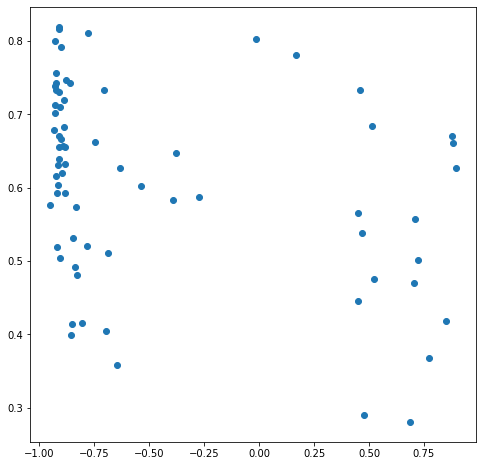

In [101]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # 主成分分析器

# 主成分分析の実行
pca = PCA()
pca.fit(cls)
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(cls)
# print(labels[line_inf])
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(8,8))
plt.scatter(cls[line_inf, 0], cls[line_inf, 1])
plt.show()

In [102]:
# 文章検索とその距離が近い文章の出力

input_sentence = input("検索文を以下に入力:")
print(input_sentence)

検索文を以下に入力:夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。
夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。


In [103]:
def make_search_w2v(input_sentence, timesteps, dictionary):
  search_w2v = []
  row_mecab = []
  pos = []
  # 各行(row)を形態素で分割
  # m = MeCab.Tagger('-Owakati')
  m = MeCab.Tagger('-chasen')
  # if not row == row:
  #   print('error')
  #   row = ' '
  node = m.parseToNode(input_sentence)
  while node:  # 文章の最後まで繰り返す\
    row_mecab.append(node.surface)  # 単語情報を抜き出す
    pos.append(node.feature.split(',')[0])  # 品詞情報を抜き出す

    node = node.next  # 次の単語


  print(row_mecab)
  # print(pos)
  vec_sentence = []
  count = 0

  for word in row_mecab:
    # print('word:', word)
    # print(pos_inf)
    #辞書に含まれていない単語を逐次追加
    if word not in dictionary:
      search_w2v.append(0)
    else:
      search_w2v.append(dictionary.index(word))

    count += 1
  #データ全体の単語INDEXを取得
  # vec_data.append(vec_sentence)
  search_w2v = np.array(search_w2v)
  print(search_w2v)
  search_w2v = np.pad(search_w2v, [timesteps-count, 0])
  # search_w2v = search_w2v.reshape(-1, timesteps)

  return search_w2v

In [104]:
search_w2v = make_search_w2v(input_sentence, timesteps, dictionary)

# 検索文に近い文章順に出力
search_w2v = search_w2v.reshape(-1, timesteps)
search = get_feature_model.predict([search_w2v])

dist = []
for i in range(len(data)):
  dist.append(np.linalg.norm(cls[i]-search))

print(dist)
sort = np.argsort(dist)
print(input_sentence)
print(data[sort[0:20]])

['', '夏', 'の', '甲子', '園', '、', '新型', 'コロナ', 'ウイルス', 'の', '影響', 'で', '松商', '学園', 'が', '不', '戦勝', '。', '']
[   1    0    7    0    0   47   69   70   71    7  655   58    0    0
   11  863 1010   17    1]
[11.60619, 7.289329, 11.897192, 13.520095, 13.484687, 12.595279, 13.25815, 11.147855, 11.5774765, 9.622116, 12.366198, 13.507279, 10.829314, 11.591113, 12.895043, 10.048434, 9.813623, 11.796124, 12.735783, 13.367205, 13.560903, 12.280574, 13.492857, 14.923057, 14.029908, 15.447337, 14.274039, 13.48882, 13.0400095, 14.813008, 14.6335535, 12.912138, 13.907794, 14.532872, 15.387716, 10.625391, 14.317352, 14.099684, 13.888202, 16.419918, 16.786024, 15.992762, 17.11485, 15.709111, 17.110598, 14.308354, 13.353859, 13.904952, 16.501541, 16.076332, 17.431095, 15.710764, 17.256937, 15.596201, 16.608114, 15.656668, 17.336094, 14.651081, 17.591814, 13.145619, 13.85801, 15.49428, 15.15259, 16.579243, 14.622484, 15.465564, 16.124838, 14.430124, 14.2659235, 15.557859]
夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。
1  

In [97]:
print(data[sort[0:20]])

1     阪神は新型コロナウイルスの感染拡大でシーズン開幕が延期される中、野球以外でファンに向けて何が...
16                       21日は守護神から先発に転向した楽天松井の登板などに注目だ。
9                            ブルペンデーで、ヤクルトの若手投手陣がアピールした。
15                    プロ野球は本来の開幕日だった3月20日から練習試合が始まっている。
13    約2週間前から杉内2軍投手コーチらのアドバイスを受け、ブルペンで10球ごとに新球へチェンジす...
2     企画発案から撮影に編集…。球団にとっても大きな負担となるが、矢野監督は「ファンがこういうのを...
7     今年初の実戦打撃では5回1死一塁でバスターを決め、内野安打。実りある試合で弾みをつけた右腕は...
12                  巨人新外国人のサンチェス投手が、21日の練習試合DeNA戦に先発する。
0     インターネットサイト「YouTube」の球団公式チャンネルが話題になっている。17日にはキャ...
17    阪神福留孝介外野手（42）が本来の開幕予定日だった20日、ヤクルトとの練習試合（神宮）でハッ...
10    先発の2年目清水は2回を無失点。3番手のドラフト4位大西は2回を完璧に抑えた。9回は、ソフト...
8     巨人阿部慎之助2軍監督が20日、41歳の誕生日を迎えた。ジャイアンツ球場で行われた2軍練習前...
5     1回は直球と得意球のカットボールで押すも、2回から組み立てを変えてカーブやフォークボールを多...
46    蜂窩（ほうか）織炎による発熱で途中休場し、11日目から再出場した西前頭15枚目千代丸（28＝...
21    浜口は神奈川大から16年ドラフト1位で入団。1年目に10勝を挙げチームの日本シリーズ進出に貢...
45    場所前には行きつけの整骨院に通い、曲がっていた背骨を矯正した。そのかいあってか、今場所も力強...
18    2回に左中間へ激走二塁打を放つと、その後も中前、右前と全方位に打ち分けた。新型コロナウイルス...
47    一時は40度まで熱が上がった体調について「もう戻った。体は元気です」と話した。この日

In [62]:
print(dist)
print(sort)

[11.60619, 7.289329, 11.897192, 13.520095, 13.484687, 12.595279, 13.25815, 11.147855, 11.5774765, 9.622116, 12.366198, 13.507279, 10.829314, 11.591113, 12.895043, 10.048434, 9.813623, 11.796124, 12.735783, 13.367205, 13.560903, 12.280574, 13.492857, 14.923057, 14.029908, 15.447337, 14.274039, 13.48882, 13.0400095, 14.813008, 14.6335535, 12.912138, 13.907794, 14.532872, 15.387716, 10.625391, 14.317352, 14.099684, 13.888202, 16.419918, 16.786024, 15.992762, 17.11485, 15.709111, 17.110598, 14.308354, 13.353859, 13.904952, 16.501541, 16.076332, 17.431095, 15.710764, 17.256937, 15.596201, 16.608114, 15.656668, 17.336094, 14.651081, 17.591814, 13.145619, 13.85801, 15.49428, 15.15259, 16.579243, 14.622484, 15.465564, 16.124838, 14.430124, 14.2659235, 15.557859]
[ 1  9 16 15 35 12  7  8 13  0 17  2 21 10  5 18 14 31 28 59  6 46 19  4
 27 22 11  3 20 60 38 47 32 24 37 68 26 45 36 67 33 64 30 57 29 23 62 34
 25 65 61 69 53 55 43 51 41 49 66 39 48 63 54 40 44 42 52 56 50 58]


**検索文入力後、文章特徴量の距離が近い文章を近い順に表示してくれるプログラム**

In [64]:
input_sentence_ex = input("検索文を以下に入力:")

search_w2v_ex = make_search_w2v(input_sentence_ex, timesteps, dictionary)

# 検索文に近い文章順に出力
search_w2v_ex = search_w2v_ex.reshape(-1, timesteps)
search_ex = get_feature_model.predict([search_w2v_ex])

dist_ex = []
for i in range(len(data)):
  dist_ex.append(np.linalg.norm(cls[i]-search_ex))

print(dist_ex)
sort_ex = np.argsort(dist_ex)
print(sort_ex)
print(input_sentence_ex)
print(data[sort_ex[0:20]])

検索文を以下に入力:三浦知良の所属する横浜FCは現在J1最下位。シーズンも後半戦を迎えており、J2降格阻止へ正念場を迎えている。
['', '三浦', '知良', 'の', '所属', 'する', '横浜', 'FC', 'は', '現在', 'J', '1', '最', '下位', '。', 'シーズン', 'も', '後半', '戦', 'を', '迎え', 'て', 'おり', '、', 'J', '2', '降格', '阻止', 'へ', '正念', '場', 'を', '迎え', 'て', 'いる', '。', '']
[   1    0    0    7    0  207  467    0   20  617  585  210  431  786
   17   74  116 1285  137   29  320   15  574   47  585   61  657    0
  373    0   99   29  320   15   16   17    1]
[11.750049, 13.236371, 12.357518, 13.091983, 13.476556, 12.756116, 13.488909, 10.979095, 14.1539755, 14.696422, 14.314573, 13.10139, 16.091068, 13.98025, 13.026462, 15.536998, 12.457187, 15.156784, 12.599987, 14.456303, 12.716157, 12.688601, 12.957963, 14.9107065, 12.497544, 14.183282, 13.594772, 11.827199, 13.513799, 10.715146, 12.702923, 10.511167, 13.334847, 14.162459, 13.675364, 11.879459, 11.981836, 14.572578, 10.816486, 15.344657, 14.369186, 14.969699, 15.558805, 14.637801, 12.963426, 14.798522, 15.055143, 15.265045, 14.797959, 12.

In [65]:
# 距離関数Dの作成（ユークリッド距離関数）
def euclidean_distance(vects):
  # print(vects)
  x, y = vects
  # print('x:', x)
  # print('y:', y)
  sum_square = tf.math.reduce_sum(tf.math.square(x-y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

# def eucl_dist_output_shape(shapes):
#   shape1, shape2 = shapes
#   return (shape1[0], 1)

In [66]:
# Contrastive Loss関数の作成
def contrastive_loss(y_true, y_pred):
  margin = 1  # margin:ハイパーパラメータ
  square_pred = tf.math.square(y_pred)
  margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
  return tf.math.reduce_mean(y_true * square_pred + (1-y_true) * margin_square)

In [67]:
# 再学習用モデルの検索文章側定義
search_sentence = Model(inputs=LSTM_AE.input, outputs=LSTM_AE.get_layer(layer_name).output)
search_feature = search_sentence.output

# 再学習用モデルの検索結果側定義
# inputs_result = Input(shape=(timesteps, ))
# result_sentence = Model(inputs=inputs, outputs=LSTM_AE.get_layer(layer_name).output)
inputs_result = Input(shape=(cls.shape[1], ))
merge_layer = Lambda(euclidean_distance)([search_feature, inputs_result])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
distance = Dense(1, activation="sigmoid")(normal_layer)

print(search_sentence.input)

reLSTM = Model(inputs=[search_sentence.input, inputs_result], outputs=distance)
reLSTM.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 239), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 239)]        0                                            
__________________________________________________________________________________________________
layer_0 (Embedding)             (None, 239, 16)      22320       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 239, 16)   0           layer_0[0][0]                    
__________________________________________________________________________________________________
layer_2x (GlobalAveragePooling2 (None, 16)    

In [68]:
%ls /drive/MyDrive/

 トーク/
 20210621_Chapter4_廣澤_配布用.ipynb
 2021_共通ゼミ_廣澤_配布用.pptx
 clustering.csv
'Colab Notebooks'/
 Colab_Notebooks/
 Example_1.csv
 Example_1.gsheet
 pytorch-openpose/
 pytorch_openpose.ipynb
 ReLSTM用データセット.csv
'○参考用語集(ver3).gdoc'
 実践プログラミングゼミ４班中間発表.gslides
 本_候補.docx
 研究時間管理表.gsheet
 領収書.pdf


In [73]:
result_tmp = pd.read_csv('/drive/MyDrive/ReLSTM用データセット.csv', encoding='cp932')
print(result_tmp)


                                                 検索文章  ...  クラスラベル
0          オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。  ...       0
1          オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。  ...       1
2          オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。  ...       0
3          オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。  ...       1
4          オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。  ...       0
5                              暴行事件で謹慎中の中田、巨人へトレード移籍。  ...       0
6                              暴行事件で謹慎中の中田、巨人へトレード移籍。  ...       1
7                              暴行事件で謹慎中の中田、巨人へトレード移籍。  ...       1
8                        夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。  ...       0
9                        夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。  ...       0
10                       夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。  ...       1
11                       夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。  ...       1
12  引退をかけて本場所に臨んだ横綱白鵬は千秋楽の大関照ノ富士との全勝同士の一番を制し、全勝優勝を...  ...       1
13  引退をかけて本場所に臨んだ横綱白鵬は千秋楽の大関照ノ富士との全勝同士の一番を制し、全勝優勝を...  ...    

In [77]:
print(result_tmp.shape[0])

21


In [ ]:
# 同じクラス(似ている文章同士)は1、似ていない文章のペアは0とする。

# result_database = []
# result_database.append([input_sentence, sort[0], data[sort[0]], 0])
# result_database.append([input_sentence, sort[1], data[sort[1]], 1])
# result_database.append([input_sentence, sort[2], data[sort[2]], 0])
# result_database.append([input_sentence, sort[3], data[sort[3]], 1])
# print(result_database)
# result_database = np.array(result_database)

[['オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。', 9, 'ブルペンデーで、ヤクルトの若手投手陣がアピールした。', 0], ['オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。', 16, '21日は守護神から先発に転向した楽天松井の登板などに注目だ。', 1], ['オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。', 7, '今年初の実戦打撃では5回1死一塁でバスターを決め、内野安打。実りある試合で弾みをつけた右腕は「あとは微調整や、やりたいことに集中できる」と先を見据えた。今後は1度登板機会を空け、次回は4月第1週の週末を予定する。そこから定められた開幕日に合わせていく。', 0], ['オリンピックの野球競技において、稲葉監督率いる侍ジャパンは悲願の金メダルを獲得した。', 15, 'プロ野球は本来の開幕日だった3月20日から練習試合が始まっている。', 1]]


In [ ]:
# cls = get_feature_model.predict([input_w2v])
# print(cls.shape)

(70, 200)


In [78]:

search_input_sentence = result_tmp['検索文章']
search_result_sentence = result_tmp['結果文章index']
tr_y = result_tmp['クラスラベル']
line_search_inf = np.arange(result_tmp.shape[0])
print(line_search_inf)
print(search_result_sentence)
tr_y = np.array(tr_y, dtype='float32')
print(tr_y)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
0     64
1      4
2     68
3     63
4     67
5     45
6     12
7     14
8      9
9     16
10    35
11    28
12    41
13    43
14    16
15     0
16     7
17     0
18    36
19    30
20    41
Name: 結果文章index, dtype: int64
[0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.]


In [79]:
print(int(search_result_sentence[0]))
print(input_w2v[42])

64
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   1 908 335  11 957 958 959 960 961   7 962 963  13  47
 892 893 894  20 964 965  29 966  15 967  15  89  39  17   4 435 111  90
 968  11 969  87 208  15 134  39  17 933 137 116  61  66 281  87 208  15
 134  39   7  58  47 970   7 904  29 971 972 973 108  39  17  58 116 971
 974 145  39   7  20 975 970  11 134  39   6  17 895 938   7 939   7 815
 942  92 391  13  82  15  47 417  11 167 946  13 116 976 158 977  52 525
  29 978  39  17   1]


In [80]:
print(input_w2v[int(search_result_sentence[0])])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    1 1295 1277 1263    7
 1284  309  153  137   47 1333  550 1334   56  557 1290 1335   19   47
 1336 

In [82]:
search_result_sentence_w2v = []

for i in range(result_tmp.shape[0]):
  search_result_sentence_w2v.append(input_w2v[int(search_result_sentence[i])])

search_result_sentence_w2v = np.array(search_result_sentence_w2v)
print(search_result_sentence_w2v.shape)


(21, 239)


In [83]:
search_result_feature = get_feature_model.predict([search_result_sentence_w2v])
print(search_result_feature.shape)

(21, 200)


In [88]:
search_input_sentence[5]

'暴行事件で謹慎中の中田、巨人へトレード移籍。'

In [89]:
search_input_sentence_w2v = []
for i in range(result_tmp.shape[0]):
  search_input_sentence_w2v.append(make_search_w2v(search_input_sentence[i], timesteps, dictionary))

# print(search_input_sentence_w2v)

['', 'オリンピック', 'の', '野球', '競技', 'に', 'おい', 'て', '、', '稲葉', '監督', '率いる', '侍', 'ジャパン', 'は', '悲願', 'の', '金', 'メダル', 'を', '獲得', 'し', 'た', '。', '']
[   1 1303    7   79    0   13    0   15   47    0   94    0    0    0
   20    0    7    0    0   29    0   38   39   17    1]
['', 'オリンピック', 'の', '野球', '競技', 'に', 'おい', 'て', '、', '稲葉', '監督', '率いる', '侍', 'ジャパン', 'は', '悲願', 'の', '金', 'メダル', 'を', '獲得', 'し', 'た', '。', '']
[   1 1303    7   79    0   13    0   15   47    0   94    0    0    0
   20    0    7    0    0   29    0   38   39   17    1]
['', 'オリンピック', 'の', '野球', '競技', 'に', 'おい', 'て', '、', '稲葉', '監督', '率いる', '侍', 'ジャパン', 'は', '悲願', 'の', '金', 'メダル', 'を', '獲得', 'し', 'た', '。', '']
[   1 1303    7   79    0   13    0   15   47    0   94    0    0    0
   20    0    7    0    0   29    0   38   39   17    1]
['', 'オリンピック', 'の', '野球', '競技', 'に', 'おい', 'て', '、', '稲葉', '監督', '率いる', '侍', 'ジャパン', 'は', '悲願', 'の', '金', 'メダル', 'を', '獲得', 'し', 'た', '。', '']
[   1 1303    7   79    0   13    0   15   4

In [90]:
search_input_sentence_w2v = np.array(search_input_sentence_w2v)
print(search_input_sentence_w2v.shape)

(21, 239)


In [91]:
path_weight2 = './my_remodel.h5'

reLSTM.compile(loss=contrastive_loss, optimizer=RMSprop())  # constrative lossを用いたモデルではoptimizerはAdamではなくRMSpropを用いるケースが多かった(根拠なしなので変更の余地あり)
reLSTM.fit([search_input_sentence_w2v, search_result_feature], 
           tr_y, 
           epochs= 300, 
           batch_size=batchsize_lstm, 
           shuffle=True, )

reLSTM.save_weights(path_weight2)

Epoch 1/300
1/1 [==============================] - 9s 9s/step - loss: 0.2804
Epoch 2/300
1/1 [==============================] - 0s 427ms/step - loss: 0.1445
Epoch 3/300
1/1 [==============================] - 0s 405ms/step - loss: 0.1011
Epoch 4/300
1/1 [==============================] - 0s 418ms/step - loss: 0.0650
Epoch 5/300
1/1 [==============================] - 0s 402ms/step - loss: 0.0492
Epoch 6/300
1/1 [==============================] - 0s 403ms/step - loss: 0.0416
Epoch 7/300
1/1 [==============================] - 0s 407ms/step - loss: 0.0424
Epoch 8/300
1/1 [==============================] - 0s 389ms/step - loss: 0.0398
Epoch 9/300
1/1 [==============================] - 0s 431ms/step - loss: 0.0317
Epoch 10/300
1/1 [==============================] - 0s 422ms/step - loss: 0.0284
Epoch 11/300
1/1 [==============================] - 0s 408ms/step - loss: 0.0271
Epoch 12/300
1/1 [==============================] - 0s 414ms/step - loss: 0.0262
Epoch 13/300
1/1 [======================

NameError: ignored

In [106]:
reLSTM.load_weights(path_weight2)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


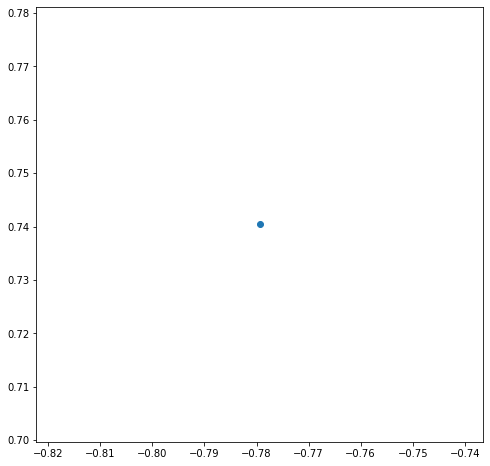

In [ ]:

# 主成分分析の実行
pca = PCA()
pca.fit(search)
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(search)
# print(labels[line_inf])
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(8,8))
plt.scatter(search[0, 0], search[0, 1])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


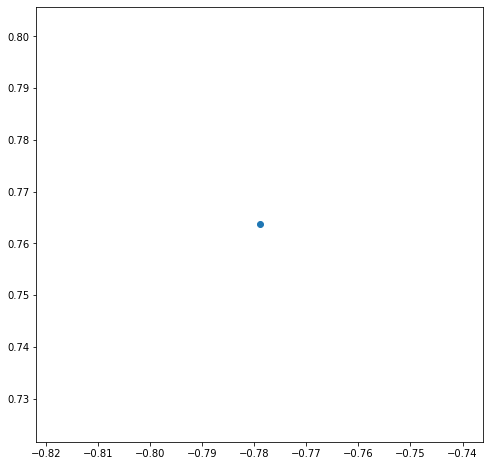

In [ ]:

# 主成分分析の実行
pca = PCA()
pca.fit(search2)
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(search2)
# print(labels[line_inf])
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(8,8))
plt.scatter(search2[0, 0], search2[0, 1])
plt.show()

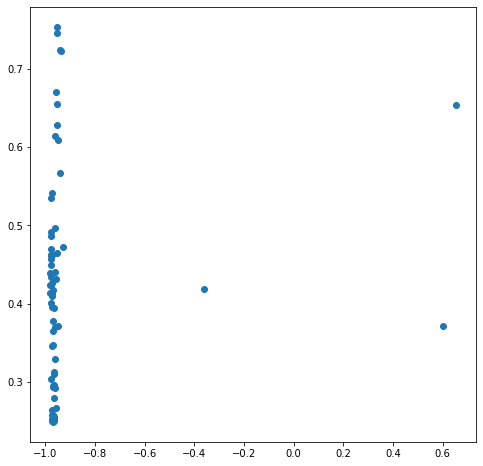

In [107]:
cls2 = get_feature_model.predict([input_w2v])

# 主成分分析の実行
pca = PCA()
pca.fit(cls2)
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(cls2)
# print(labels[line_inf])
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(8,8))
plt.scatter(cls2[line_inf, 0], cls2[line_inf, 1])
plt.show()

In [113]:
search_w2v2 = make_search_w2v(input_sentence, timesteps, dictionary)

# 検索文に近い文章順に出力
search_w2v2 = search_w2v2.reshape(-1, timesteps)
search2 = get_feature_model.predict([search_w2v2])

dist2 = []
for i in range(len(data)):
  dist2.append(np.linalg.norm(cls2[i]-search2))

print(dist2)
sort2 = np.argsort(dist2)
print(sort2)
print(input_sentence)
print(data[sort2[0:20]])

['', '夏', 'の', '甲子', '園', '、', '新型', 'コロナ', 'ウイルス', 'の', '影響', 'で', '松商', '学園', 'が', '不', '戦勝', '。', '']
[   1    0    7    0    0   47   69   70   71    7  655   58    0    0
   11  863 1010   17    1]
[11.937191, 9.275287, 12.063947, 12.467684, 13.158714, 12.258073, 12.950623, 12.579599, 8.32902, 8.574096, 10.443934, 13.26057, 6.358309, 5.93308, 13.927605, 5.923301, 6.649548, 9.772929, 13.627724, 13.051834, 13.283286, 12.286848, 11.659482, 13.458756, 10.792719, 13.645281, 12.750891, 11.240231, 13.972383, 11.372501, 12.705611, 10.667471, 12.185158, 15.33211, 13.784128, 5.7280374, 13.464687, 13.69492, 12.026132, 15.729927, 13.80745, 14.594473, 12.578789, 14.925783, 12.42527, 11.660424, 13.742016, 11.915233, 14.315142, 12.365778, 13.355773, 14.527607, 14.408342, 13.75589, 13.348898, 11.802179, 12.80746, 11.666447, 13.209088, 11.164155, 11.698257, 13.695509, 11.938202, 14.021385, 13.524063, 14.518519, 12.975325, 13.174511, 12.94833, 9.438634]
[35 15 13 12 16  8  9  1 69 17 10 31 24 59 27

In [114]:
print(input_sentence)
print('1回目学習後')
print(data[sort[0:20]])
print('距離再計算学習後')
print(data[sort2[0:20]])
print(sort2)

夏の甲子園、新型コロナウイルスの影響で松商学園が不戦勝。
1回目学習後
1     阪神は新型コロナウイルスの感染拡大でシーズン開幕が延期される中、野球以外でファンに向けて何が...
9                            ブルペンデーで、ヤクルトの若手投手陣がアピールした。
16                       21日は守護神から先発に転向した楽天松井の登板などに注目だ。
15                    プロ野球は本来の開幕日だった3月20日から練習試合が始まっている。
35    新型コロナウイルスの感染拡大の影響で2月下旬から公式戦中断中のJリーグは19日に臨時実行委員...
12                  巨人新外国人のサンチェス投手が、21日の練習試合DeNA戦に先発する。
7     今年初の実戦打撃では5回1死一塁でバスターを決め、内野安打。実りある試合で弾みをつけた右腕は...
8     巨人阿部慎之助2軍監督が20日、41歳の誕生日を迎えた。ジャイアンツ球場で行われた2軍練習前...
13    約2週間前から杉内2軍投手コーチらのアドバイスを受け、ブルペンで10球ごとに新球へチェンジす...
0     インターネットサイト「YouTube」の球団公式チャンネルが話題になっている。17日にはキャ...
17    阪神福留孝介外野手（42）が本来の開幕予定日だった20日、ヤクルトとの練習試合（神宮）でハッ...
2     企画発案から撮影に編集…。球団にとっても大きな負担となるが、矢野監督は「ファンがこういうのを...
21    浜口は神奈川大から16年ドラフト1位で入団。1年目に10勝を挙げチームの日本シリーズ進出に貢...
10    先発の2年目清水は2回を無失点。3番手のドラフト4位大西は2回を完璧に抑えた。9回は、ソフト...
5     1回は直球と得意球のカットボールで押すも、2回から組み立てを変えてカーブやフォークボールを多...
18    2回に左中間へ激走二塁打を放つと、その後も中前、右前と全方位に打ち分けた。新型コロナウイルス...
14    日本流を落とし込みながら、投球では「これまでと同じアプローチでやっていくよ」と昨季韓国で17...
31       J1湘

In [115]:
dist = np.array(dist)
dist2 = np.array(dist2)

diff=dist-dist2
diff_sort = np.argsort(diff)
print(diff)
print(diff_sort)

[-0.33100128 -1.9859576  -0.16675472  1.0524111   0.32597256  0.3372059
  0.30752754 -1.4317446   3.248457    1.0480204   1.9222631   0.24670982
  4.4710054   5.658033   -1.0325613   4.125133    3.1640754   2.0231953
 -0.8919411   0.31537056  0.2776165  -0.00627422  1.833375    1.4643002
  3.2371893   1.8020563   1.5231485   2.2485895  -0.93237305  3.440507
  1.9279423   2.244667    1.7226362  -0.7992382   1.6035881   4.8973536
  0.85266495  0.40476418  1.8620701   0.689991    2.9785738   1.3982887
  4.5360603   0.78332806  4.6853275   2.6479301  -0.3881569   1.9897194
  2.1863995   3.7105541   4.075322    1.183157    2.8485947   1.840311
  3.2592163   3.8544884   4.528634    2.9846344   4.3827257   1.9814644
  2.1597528   1.7987709   3.214388    2.5578575   1.0984211   0.9470444
  3.1495132   1.2556133   1.3175936   6.1192255 ]
[ 1  7 14 28 18 33 46  0  2 21 11 20  6 19  4  5 37 39 43 36 65  9  3 64
 51 67 68 41 23 26 34 32 61 25 22 53 38 10 30 59 47 17 60 48 31 27 63 45
 52 40 57 66 

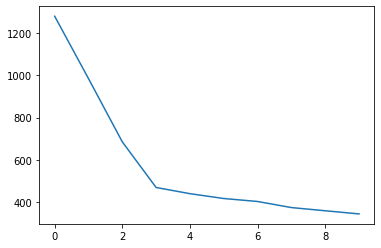

In [ ]:
import matplotlib.pyplot as plt
max_cluster_num = 10

# エルボー法で最適なクラスタ数を探索する
sse = np.zeros((max_cluster_num, ))
se = np.zeros((max_cluster_num, ))
inertia = np.zeros((max_cluster_num, ))

for i in range(max_cluster_num):
  cluster_num = i+1
  kmeans = KMeans(n_clusters = cluster_num)
  pred = kmeans.fit_predict(cls)
  inertia[i] = kmeans.inertia_

  transforms = kmeans.transform(cls)
  distances = np.zeros((cls.shape[0]))

  for index in range(len(transforms)):
    distances[index] = transforms[index, pred[index]]

  se[i] = np.sum(distances)
  sse[i] = np.sum(distances**2)

a = np.arange(10)
plt.plot(a, inertia)

plt.show()

In [ ]:
c_num = 3
pred_3 = KMeans(n_clusters = c_num).fit(cls)
print(pred_3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [ ]:
print(sse)

[1277.96008296  961.45446324  685.65841581  470.58130386  445.51222423
  421.40599282  393.3658018   380.00818891  357.7934451   349.44024254]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0]


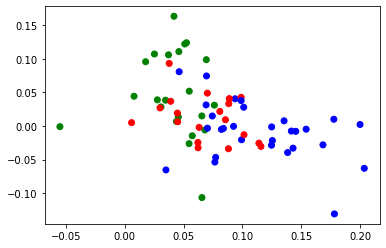

In [ ]:
from sklearn.decomposition import PCA  # 主成分分析器

labels = pred_3.labels_

labels = np.array(labels)
colors = ["r" ,"g", "b"]
colors = np.array(colors)
print(labels)

# 主成分分析の実行
pca = PCA()
pca.fit(cls)
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(cls)
# print(labels.shape)
# print(colors)
# print(labels[line_inf])
# print(colors[labels])
# 第一主成分と第二主成分でプロットする
# plt.figure(figsize=(8,8))
plt.scatter(cls[line_inf, 0], cls[line_inf, 1], c=colors[labels])
plt.show()

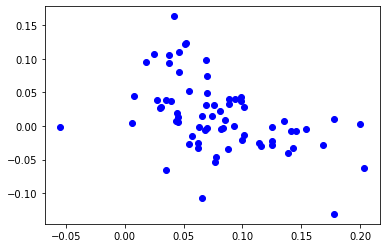

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(cls[line_inf, 0], cls[line_inf, 1], c="b")
plt.show()

In [ ]:
print(cls[0][1])
print(cls[0][2])
print(cls[0][188])
print(cls[0][189])
print(cls[0][190])
print(cls[0][191])
print()
print(input_w2v[0]) # 指定されたseq番号の単語特徴量

0.716723
0.5509514
-0.42319265
0.56826204
-0.81666684
-0.6045787

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.
 11. 12. 13. 14. 15. 16. 17. 18. 19. 13. 20. 21.  7. 22. 11. 23. 24. 13.
 25. 26. 27. 13. 28. 29. 30. 31. 29. 32. 17. 33. 19. 13. 20. 34. 35. 29.
 36. 13. 37. 38. 39. 40. 41. 42.  7. 43. 44. 45. 46. 11. 47. 48. 49. 50.
  7. 51. 52. 53. 54. 13. 55. 38. 15. 16. 56. 57. 20.  8.  7.  9. 10. 58.
 59. 17. 25. 27.  7. 28. 31. 20. 47. 60. 61. 19. 58. 62. 6

In [ ]:
# Embedding後の各単語の特徴量

# print(cls[7][1])    # padding(7は適当)
# print(cls[7][23])   # padding
# print(cls[7][186])  # 普通の単語
# print(cls.shape)

# [-0.7045435  -1.9852313   1.2020841   3.497596    0.21511011  0.503387
#   2.4495409   6.1879616   3.6204557  -0.60159874  1.5071025   0.31605506
#  -0.01150608 -0.44549415  1.4367023   1.9446754 ]
# [-0.7045435  -1.9852313   1.2020841   3.497596    0.21511011  0.503387
#   2.4495409   6.1879616   3.6204557  -0.60159874  1.5071025   0.31605506
#  -0.01150608 -0.44549415  1.4367023   1.9446754 ]
# [-2.4816272   1.236034    0.271418    0.5273086   0.22198428 -0.29935843
#  -2.7889354   2.3024821   0.29362816 -0.9283478  -1.0853043   0.08451311
#  -1.841284    0.57333696 -1.3197367  -0.17667502]
# (70, 238, 16)

[-0.7045435  -1.9852313   1.2020841   3.497596    0.21511011  0.503387
  2.4495409   6.1879616   3.6204557  -0.60159874  1.5071025   0.31605506
 -0.01150608 -0.44549415  1.4367023   1.9446754 ]
[-0.7045435  -1.9852313   1.2020841   3.497596    0.21511011  0.503387
  2.4495409   6.1879616   3.6204557  -0.60159874  1.5071025   0.31605506
 -0.01150608 -0.44549415  1.4367023   1.9446754 ]
[-2.4816272   1.236034    0.271418    0.5273086   0.22198428 -0.29935843
 -2.7889354   2.3024821   0.29362816 -0.9283478  -1.0853043   0.08451311
 -1.841284    0.57333696 -1.3197367  -0.17667502]
(70, 238, 16)


In [ ]:

c_num = 10
km = KMeans(n_clusters=c_num).fit(cls)

labels = km.labels_
distance = np.min(km.transform(cls), axis=1)

path_pd = '/drive/MyDrive/clustering.csv'

df = pd.DataFrame()
df.to_csv(path_pd, mode='w', index=False)

for i in range(c_num):
  df = pd.DataFrame(columns=['Cluster #'])
  df = df.append({'Cluster # ': i}, ignore_index=True)
  df.to_csv(path_pd, mode='a', index=False)

  c_index = np.array(np.where(labels==i)).reshape(-1)
  c_distance=distance[c_index]
  sorted_c_index = c_index[np.argsort(c_distance)]
  print(sorted_c_index)

  df = pd.DataFrame(columns=['文書番号', 'クラスタ中心からの距離', '文書'])

  for j in sorted_c_index:
    df = df.append({'文書番号':j, 'クラスタ中心からの距離':distance[j], '文書':data[j]}, ignore_index=True)

  df.to_csv(path_pd, mode='a', index=False)


[17  0 19]
[34 30 28 56 31 65 23 55]
[37 33 32 25 38]
[53 50 41 40 48 46 49 45 39 52  9]
[68 60 69 58]
[67 59 66 57 63 62 64 61]
[16 12 15  1 13]
[10  4  5  3  6 20 11  7  8  2 18 21 14]
[36 24 35 26 29 27 22]
[43 54 42 44 51 47]


In [ ]:

sentence_no = 10

layer_name = 'layer_6x'
model_tiral = Model(inputs=LSTM_AE.input, outputs=LSTM_AE.get_layer(layer_name).output)
att_vis = model_trial.predict([input_w2v])

# attentionの特徴量を成形(次元削減＆正規化)
from sklearn import preprocessing

att_vis = np.squeeze(att_vis)

ss = preprocessing.MinMaxScaler()
att_vis = ss.fit_transform(att_vis)

# 文書番号をsentence_noに格納するとAttentionで色付けして出力
for i in range(len(vec_data[sentence_no])):
  grey = 200 - int(200 * att_vis[sentence_no][i])
  print("\033[38;2;" + str(grey) + ";" + str(grey) + ";" + str(grey) + "m" + dictionary[vec_data[sentence_no][i]] + "\033[0m", end = ' ')


先発 の 2 年 目 清水 は 2 回 を 無 失点 。 3 番手 の ドラフト 4 位 大西 は 2 回 を 完璧 に 抑え た 。 9 回 は 、 ソフト バンク の 育成 から 新 加入 し た 左腕 長谷川 が わずか 7 球 で 3 者 凡退 。 
 

In [ ]:

# loss_list = []
# loss_list.extend(result.history['loss'])
print(loss_list)
print(np.array(loss_list).shape)

[6.401927471160889, 6.2403106689453125, 6.249670028686523, 6.1136064529418945, 6.006901264190674, 5.844775676727295, 5.685949802398682, 5.563150405883789, 5.355846405029297, 5.271862030029297, 5.838228225708008, 5.78462553024292, 5.745098114013672, 5.640793800354004, 5.539499282836914, 5.452040195465088, 5.288724422454834, 5.2187089920043945, 4.987415790557861, 4.878882884979248, 5.788774013519287, 5.825491428375244, 5.784441947937012, 5.609563827514648, 5.561429977416992, 5.385857582092285, 5.309630870819092, 5.200871467590332, 5.007061004638672, 4.9111456871032715, 6.0971245765686035, 6.014912128448486, 5.90290641784668, 5.808718681335449, 5.729406833648682, 5.558047294616699, 5.390603542327881, 5.290581703186035, 5.1156229972839355, 4.956219673156738, 5.50606632232666, 5.456737995147705, 5.4428606033325195, 5.317091941833496, 5.219941139221191, 5.152580261230469, 4.976334095001221, 4.87598991394043, 4.766567707061768, 4.615355968475342, 6.036299228668213, 5.925957202911377, 5.859058

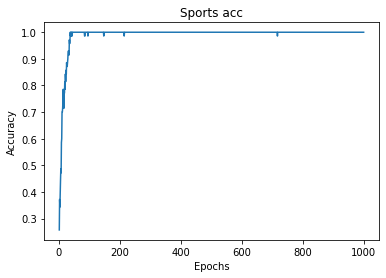

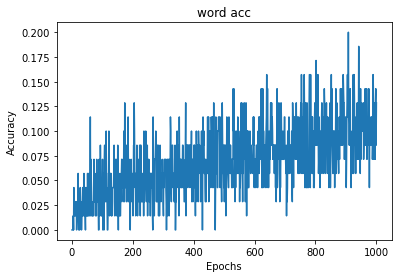

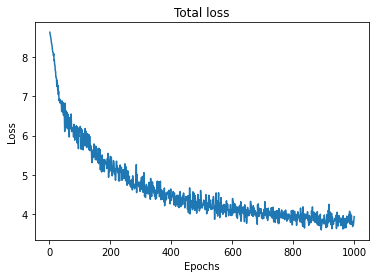

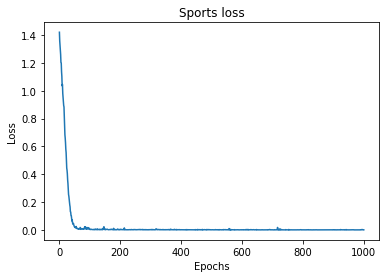

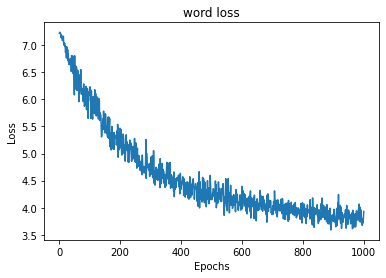

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch=1000

# out_loss_list = []
# out_2_loss_list = []
# out_acc_list = []
# out_2_acc_list = []

fig=plt.figure()
plt.plot(range(1, epoch+1),
         out_acc_list)
plt.title('Sports acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

fig=plt.figure()
plt.plot(range(1, epoch+1),
         out_2_acc_list)
plt.title('word acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

fig=plt.figure()
plt.plot(range(1, epoch+1),
         loss_list)
plt.title('Total loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

fig=plt.figure()
plt.plot(range(1, epoch+1),
         out_loss_list)
plt.title('Sports loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

fig=plt.figure()
plt.plot(range(1, epoch+1),
         out_2_loss_list)
plt.title('word loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

